폰트설정  
1. 아래 코드 실행  
2. 런타임 다시 시작

In [ ]:
 !sudo apt-get install -y fonts-nanum
 !sudo fc-cache -fv
 !rm ~/.cache/matplotlib -rf

##import

### import

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install pycaret

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.4/484.4 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.4/153.4 kB 11.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.8/81.8 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 57.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 36.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 42.1 MB/s eta 0:0

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import holidays
import matplotlib.pyplot as plt
import seaborn as sns
from pycaret.regression import *
from sklearn.cluster import KMeans
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
import plotly.graph_objects as go
from xgboost import XGBRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
import joblib
from sktime.forecasting.model_selection import temporal_train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler


### 메소드

In [ ]:
def check_holiday(target_df):
  # 주말 여부 확인하여 저장, 주말:true 평일:false
  target_df['holiday'] = target_df['일시'].dt.weekday >= 5

  # 한국의 공휴일 여부 확인하여 저장
  korea_holidays = holidays.KR()
  target_df['공휴일'] = target_df['일시'].apply(lambda x: x in korea_holidays)

  # 공휴일인 경우 holiday 값을 true로 변경
  target_df.loc[target_df['공휴일'], 'holiday'] = True

  return target_df

def make_ymd_feature(target_df):
  # 일시 데이터를 년, 월, 일, 시간으로 나누어 새로운 컬럼 추가
  #target_df['년'] = target_df['일시'].dt.year
  target_df['월'] = target_df['일시'].dt.month
  target_df['일'] = target_df['일시'].dt.day
  target_df['시간'] = target_df['일시'].dt.hour

  return target_df

# 불쾌지수 계산 함수 정의
def calculate_discomfort_index(temperature, humidity):
    return 0.81 * temperature + 0.01 * humidity * (0.99 * temperature - 14.3) + 46.3

# 불쾌지수 이동평균 계산 함수
def calculate_discomfort_moving_average(df):
  df['불쾌지수_이동평균3'] = df.groupby('건물번호')['불쾌지수'].rolling(window=3, min_periods=1).mean().reset_index(level=0, drop=True)
  df['불쾌지수_이동평균5'] = df.groupby('건물번호')['불쾌지수'].rolling(window=5, min_periods=1).mean().reset_index(level=0, drop=True)

# smape 계산 함수
def smape_fnc(true, pred):
  v = 2*abs(pred-true)/(abs(pred)+abs(true))
  output=np.mean(v)*100
  return output

def change_date_sin(df):
  # 월, 일, 시간 컬럼에서 각각 값을 가져옴
  month = df['월']
  day = df['일']
  hour = df['시간']

  # 각각의 주기를 설정 (월: 12개, 일: 31개, 시간: 24개)
  max_month = 12
  max_day = 31
  max_hour = 24

  # sin-cos 변환 수식 적용
  #df['월_sin'] = np.sin(2 * np.pi * month / max_month)
  #df['일_sin'] = np.sin(2 * np.pi * day / max_day)
  #df['월_cos'] = np.cos(2 * np.pi * month / max_month)
  #df['일_cos'] = np.cos(2 * np.pi * day / max_day)

  df['시간_sin'] = np.sin(2 * np.pi * hour / max_hour)
  df['시간_cos'] = np.cos(2 * np.pi * hour / max_hour)

### 데이터 불러오기

In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/dacon/'

In [ ]:
train_df = pd.read_csv(path + 'train.csv')
binfo_df = pd.read_csv(path + 'building_info.csv')
test_df = pd.read_csv(path + 'test.csv')

## train 데이터

In [ ]:
# 강수량, 일조, 일사 컬럼 삭제
train_df = train_df.drop(columns=['강수량(mm)', '일조(hr)', '일사(MJ/m2)'])

# 풍속과 습도 값이 NaN일 때 전 행의 값으로 치환
train_df['풍속(m/s)'].fillna(method='ffill', inplace=True)
train_df['습도(%)'].fillna(method='ffill', inplace=True)

# 기온 Min-Max 정규화 수행
#scaler = MinMaxScaler()
#train_df[['기온_정규화']] = scaler.fit_transform(train_df[['기온(C)']])

# 불쾌지수 계산 후 새로운 컬럼 추가
train_df['불쾌지수'] = calculate_discomfort_index(train_df['기온(C)'], train_df['습도(%)'])

# 불쾌지수 이동평균 (3, 5) 계산 후 컬럼 추가
calculate_discomfort_moving_average(train_df)

# '일시' 열을 날짜 형식으로 변환
train_df['일시'] = pd.to_datetime(train_df['일시'], format='%Y%m%d %H')

# holiday 컬럼 추가
train_df = check_holiday(train_df)

# 년, 월, 일, 시간 컬럼 추가
train_df = make_ymd_feature(train_df)

# 월, 일, 시간 sin 값으로 바꾼 후 컬럼 추가
change_date_sin(train_df)

# 요일 컬럼 추가
train_df['요일'] = train_df['일시'].dt.dayofweek  # 요일을 0(월요일)부터 6(일요일)까지의 정수로 저장

# 컬럼 삭제
train_df.drop(columns=['num_date_time','공휴일'], inplace=True) # '일시'

# csv 파일로 저장
#train_df.to_csv('train_p.csv', index=False)

train_df

,건물번호,일시,기온(C),풍속(m/s),습도(%),전력소비량(kWh),불쾌지수,불쾌지수_이동평균3,불쾌지수_이동평균5,holiday,월,일,시간,시간_sin,시간_cos,요일
0,1,2022-06-01 00:00:00,18.6,0.9,42.0,1085.28,63.09388,63.093880,63.093880,True,6,1,0,0.000000,1.000000,2
1,1,2022-06-01 01:00:00,18.0,1.1,45.0,1047.36,62.46400,62.778940,62.778940,True,6,1,1,0.258819,0.965926,2
2,1,2022-06-01 02:00:00,17.7,1.5,45.0,974.88,62.08735,62.548410,62.548410,True,6,1,2,0.500000,0.866025,2
3,1,2022-06-01 03:00:00,16.7,1.4,48.0,953.76,60.89884,61.816730,62.136017,True,6,1,3,0.707107,0.707107,2
4,1,2022-06-01 04:00:00,18.4,2.8,43.0,986.40,62.88788,61.958023,62.286390,True,6,1,4,0.866025,0.500000,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203995,100,2022-08-24 19:00:00,23.1,0.9,86.0,881.04,72.38034,74.061867,74.322108,False,8,24,19,-0.965926,0.258819,2
203996,100,2022-08-24 20:00:00,22.4,1.3,86.0,798.96,71.21736,72.678320,73.678128,False,8,24,20,-0.866025,0.500000,2
203997,100,2022-08-24 21:00:00,21.3,1.0,92.0,825.12,69.79704,71.131580,72.640000,False,8,24,21,-0.707107,0.707107,2
203998,100,2022-08-24 22:00:00,21.0,0.3,94.0,640.08,69.41060,70.141667,71.448520,False,8,24,22,-0.500000,0.866025,2


In [ ]:
train_df.columns.tolist()

['건물번호',
 '일시',
 '기온(C)',
 '풍속(m/s)',
 '습도(%)',
 '전력소비량(kWh)',
 '불쾌지수',
 '불쾌지수_이동평균3',
 '불쾌지수_이동평균5',
 'holiday',
 '월',
 '일',
 '시간',
 '시간_sin',
 '시간_cos',
 '요일']

## buliding_info 데이터

In [ ]:
#  '-'인 경우 0으로 대체
binfo_df = binfo_df.replace('-', 0)

# 건물유형 원-핫 인코딩
one_hot_encoded = pd.get_dummies(binfo_df['건물유형'])
binfo_df = pd.concat([binfo_df, one_hot_encoded], axis=1)

# 라벨 인코더 생성 및 적용
label_encoder = LabelEncoder()
binfo_df['건물유형_라벨'] = label_encoder.fit_transform(binfo_df['건물유형'])+1

# 문자열을 숫자로 변환
binfo_df['태양광용량(kW)'] = binfo_df['태양광용량(kW)'].astype(float)
binfo_df['ESS저장용량(kWh)'] = binfo_df['ESS저장용량(kWh)'].astype(float)
binfo_df['PCS용량(kW)'] = binfo_df['PCS용량(kW)'].astype(float)

#로그변환
binfo_df['연면적(m2)'] = binfo_df['연면적(m2)'].map(lambda x:np.log(x) if x > 0 else 0)
binfo_df['냉방면적(m2)'] = binfo_df['냉방면적(m2)'].map(lambda x:np.log(x) if x > 0 else 0)
binfo_df['태양광용량(kW)'] = binfo_df['태양광용량(kW)'].map(lambda x:np.log(x) if x > 0 else 0)
binfo_df['ESS저장용량(kWh)'] = binfo_df['ESS저장용량(kWh)'].map(lambda x:np.log(x) if x > 0 else 0)
binfo_df['PCS용량(kW)'] = binfo_df['PCS용량(kW)'].map(lambda x:np.log(x) if x > 0 else 0)

# 컬럼 삭제
binfo_df.drop(columns=['PCS용량(kW)'], inplace=True)

#태양광 여부 컬럼 추가
binfo_df['태양광여부'] = binfo_df['태양광용량(kW)'] != 0


# csv 파일로 저장
#df.to_csv('building_info_p.csv', index=False)

binfo_df

,건물번호,건물유형,연면적(m2),냉방면적(m2),태양광용량(kW),ESS저장용량(kWh),건물기타,공공,대학교,데이터센터,백화점및아울렛,병원,상용,아파트,연구소,지식산업센터,할인마트,호텔및리조트,건물유형_라벨,태양광여부
0,1,건물기타,11.613983,10.585827,0.000000,0.00000,1,0,0,0,0,0,0,0,0,0,0,0,1,False
1,2,건물기타,11.713688,11.502875,0.000000,0.00000,1,0,0,0,0,0,0,0,0,0,0,0,1,False
2,3,건물기타,12.050839,11.643515,3.688879,0.00000,1,0,0,0,0,0,0,0,0,0,0,0,1,True
3,4,건물기타,11.216041,10.446382,4.094345,0.00000,1,0,0,0,0,0,0,0,0,0,0,0,1,True
4,5,건물기타,12.235068,11.918391,0.000000,7.84659,1,0,0,0,0,0,0,0,0,0,0,0,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,96,호텔및리조트,11.443725,11.010399,0.000000,0.00000,0,0,0,0,0,0,0,0,0,0,0,1,12,False
96,97,호텔및리조트,10.917715,10.161226,0.000000,0.00000,0,0,0,0,0,0,0,0,0,0,0,1,12,False
97,98,호텔및리조트,10.888905,9.762716,0.000000,0.00000,0,0,0,0,0,0,0,0,0,0,0,1,12,False
98,99,호텔및리조트,10.887418,10.612410,0.000000,0.00000,0,0,0,0,0,0,0,0,0,0,0,1,12,False


In [ ]:
sorted_df = binfo_df.sort_values(by='냉방면적(m2)')
sorted_df

,건물번호,건물유형,연면적(m2),냉방면적(m2),태양광용량(kW),ESS저장용량(kWh),건물기타,공공,대학교,데이터센터,백화점및아울렛,병원,상용,아파트,연구소,지식산업센터,할인마트,호텔및리조트,건물유형_라벨,태양광여부
65,66,아파트,11.562411,0.000000,0.000000,0.0,0,0,0,0,0,0,0,1,0,0,0,0,8,False
67,68,아파트,12.872352,0.000000,0.000000,0.0,0,0,0,0,0,0,0,1,0,0,0,0,8,False
76,77,지식산업센터,11.118061,0.000000,0.000000,0.0,0,0,0,0,0,0,0,0,0,1,0,0,10,False
64,65,아파트,12.121816,0.000000,0.000000,0.0,0,0,0,0,0,0,0,1,0,0,0,0,8,False
79,80,지식산업센터,12.454378,5.476464,0.000000,0.0,0,0,0,0,0,0,0,0,0,1,0,0,10,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24,25,대학교,13.176878,12.820751,3.912023,0.0,0,0,1,0,0,0,0,0,0,0,0,0,3,True
26,27,대학교,13.268166,13.125123,3.401197,0.0,0,0,1,0,0,0,0,0,0,0,0,0,3,True
23,24,대학교,13.399536,13.154052,4.581390,0.0,0,0,1,0,0,0,0,0,0,0,0,0,3,True
60,61,아파트,13.410742,13.197866,0.000000,0.0,0,0,0,0,0,0,0,1,0,0,0,0,8,False


In [ ]:
binfo_df.columns.tolist()

['건물번호',
 '건물유형',
 '연면적(m2)',
 '냉방면적(m2)',
 '태양광용량(kW)',
 'ESS저장용량(kWh)',
 '건물기타',
 '공공',
 '대학교',
 '데이터센터',
 '백화점및아울렛',
 '병원',
 '상용',
 '아파트',
 '연구소',
 '지식산업센터',
 '할인마트',
 '호텔및리조트',
 '건물유형_라벨',
 '태양광여부']

## test 데이터

In [ ]:

# 기온 Min-Max 정규화 수행
#scaler = MinMaxScaler()
#df[['기온_정규화']] = scaler.fit_transform(df[['기온(C)']])

# 불쾌지수 계산 후 새로운 컬럼 추가
test_df['불쾌지수'] = calculate_discomfort_index(test_df['기온(C)'], test_df['습도(%)'])

# 불쾌지수 이동평균 (3, 5) 계산 후 컬럼 추가
calculate_discomfort_moving_average(test_df)

# '일시' 열을 날짜 형식으로 변환
test_df['일시'] = pd.to_datetime(test_df['일시'], format='%Y%m%d %H')

# holiday 컬럼 추가
test_df = check_holiday(test_df)

# 월, 일, 시간 컬럼 추가
test_df = make_ymd_feature(test_df)

# 월, 일, 시간 sin 값으로 바꾼 후 컬럼 추가
change_date_sin(test_df)

# 요일 컬럼 추가
test_df['요일'] = test_df['일시'].dt.dayofweek  # 요일을 0(월요일)부터 6(일요일)까지의 정수로 저장

# 건물번호로 binfo_df 연결 (left join)
test_df = pd.merge(test_df, binfo_df, on='건물번호', how='left')

# 컬럼 삭제
test_df.drop(columns=['num_date_time','강수량(mm)', '공휴일', '건물유형'], inplace=True) #'건물번호',

# csv 파일로 저장
#test_df.to_csv('test_p.csv', index=False)

test_df

,건물번호,일시,기온(C),풍속(m/s),습도(%),불쾌지수,불쾌지수_이동평균3,불쾌지수_이동평균5,holiday,월,...,백화점및아울렛,병원,상용,아파트,연구소,지식산업센터,할인마트,호텔및리조트,건물유형_라벨,태양광여부
0,1,2022-08-25 00:00:00,23.5,2.2,72,71.78980,71.789800,71.789800,False,8,...,0,0,0,0,0,0,0,0,1,False
1,1,2022-08-25 01:00:00,23.0,0.9,72,71.02840,71.409100,71.409100,False,8,...,0,0,0,0,0,0,0,0,1,False
2,1,2022-08-25 02:00:00,22.7,1.5,75,70.81675,71.211650,71.211650,False,8,...,0,0,0,0,0,0,0,0,1,False
3,1,2022-08-25 03:00:00,22.1,1.3,78,70.11262,70.652590,70.936892,False,8,...,0,0,0,0,0,0,0,0,1,False
4,1,2022-08-25 04:00:00,21.8,1.0,77,69.56514,70.164837,70.662542,False,8,...,0,0,0,0,0,0,0,0,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16795,100,2022-08-31 19:00:00,22.5,0.9,84,71.22400,72.378973,72.792244,False,8,...,0,0,0,0,0,0,0,1,12,False
16796,100,2022-08-31 20:00:00,20.7,0.4,95,68.95035,70.961363,71.899884,False,8,...,0,0,0,0,0,0,0,1,12,False
16797,100,2022-08-31 21:00:00,20.2,0.4,98,68.24604,69.473463,70.866662,False,8,...,0,0,0,0,0,0,0,1,12,False
16798,100,2022-08-31 22:00:00,20.1,1.1,97,68.01203,68.402807,69.828432,False,8,...,0,0,0,0,0,0,0,1,12,False


In [ ]:
test_df.columns.tolist()

['건물번호',
 '일시',
 '기온(C)',
 '풍속(m/s)',
 '습도(%)',
 '불쾌지수',
 '불쾌지수_이동평균3',
 '불쾌지수_이동평균5',
 'holiday',
 '월',
 '일',
 '시간',
 '시간_sin',
 '시간_cos',
 '요일',
 '연면적(m2)',
 '냉방면적(m2)',
 '태양광용량(kW)',
 'ESS저장용량(kWh)',
 '건물기타',
 '공공',
 '대학교',
 '데이터센터',
 '백화점및아울렛',
 '병원',
 '상용',
 '아파트',
 '연구소',
 '지식산업센터',
 '할인마트',
 '호텔및리조트',
 '건물유형_라벨',
 '태양광여부']

## combined 데이터

In [ ]:
# 건물번호로 train_df와 binfo_df 연결 (left join)
combined_df = pd.merge(train_df, binfo_df, on='건물번호', how='left')

combined_df

,건물번호,일시,기온(C),풍속(m/s),습도(%),전력소비량(kWh),불쾌지수,불쾌지수_이동평균3,불쾌지수_이동평균5,holiday,...,백화점및아울렛,병원,상용,아파트,연구소,지식산업센터,할인마트,호텔및리조트,건물유형_라벨,태양광여부
0,1,2022-06-01 00:00:00,18.6,0.9,42.0,1085.28,63.09388,63.093880,63.093880,True,...,0,0,0,0,0,0,0,0,1,False
1,1,2022-06-01 01:00:00,18.0,1.1,45.0,1047.36,62.46400,62.778940,62.778940,True,...,0,0,0,0,0,0,0,0,1,False
2,1,2022-06-01 02:00:00,17.7,1.5,45.0,974.88,62.08735,62.548410,62.548410,True,...,0,0,0,0,0,0,0,0,1,False
3,1,2022-06-01 03:00:00,16.7,1.4,48.0,953.76,60.89884,61.816730,62.136017,True,...,0,0,0,0,0,0,0,0,1,False
4,1,2022-06-01 04:00:00,18.4,2.8,43.0,986.40,62.88788,61.958023,62.286390,True,...,0,0,0,0,0,0,0,0,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203995,100,2022-08-24 19:00:00,23.1,0.9,86.0,881.04,72.38034,74.061867,74.322108,False,...,0,0,0,0,0,0,0,1,12,False
203996,100,2022-08-24 20:00:00,22.4,1.3,86.0,798.96,71.21736,72.678320,73.678128,False,...,0,0,0,0,0,0,0,1,12,False
203997,100,2022-08-24 21:00:00,21.3,1.0,92.0,825.12,69.79704,71.131580,72.640000,False,...,0,0,0,0,0,0,0,1,12,False
203998,100,2022-08-24 22:00:00,21.0,0.3,94.0,640.08,69.41060,70.141667,71.448520,False,...,0,0,0,0,0,0,0,1,12,False


In [ ]:
combined_df.columns.tolist()

['건물번호',
 '일시',
 '기온(C)',
 '풍속(m/s)',
 '습도(%)',
 '전력소비량(kWh)',
 '불쾌지수',
 '불쾌지수_이동평균3',
 '불쾌지수_이동평균5',
 'holiday',
 '월',
 '일',
 '시간',
 '시간_sin',
 '시간_cos',
 '요일',
 '건물유형',
 '연면적(m2)',
 '냉방면적(m2)',
 '태양광용량(kW)',
 'ESS저장용량(kWh)',
 '건물기타',
 '공공',
 '대학교',
 '데이터센터',
 '백화점및아울렛',
 '병원',
 '상용',
 '아파트',
 '연구소',
 '지식산업센터',
 '할인마트',
 '호텔및리조트',
 '건물유형_라벨',
 '태양광여부']

## 군집화

건물유형 별 전력소비량 그래프

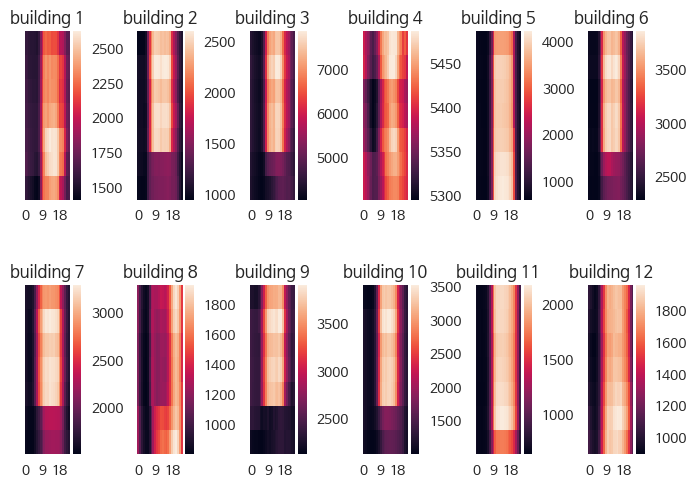

In [ ]:
# energy usage of each building ~ weekday, hour
#fig = plt.figure(figsize = (15, 40))
plt.subplots_adjust(hspace=0.5, wspace=1)  # 간격 조절
for num in combined_df['건물유형_라벨'].unique():
    df = combined_df[combined_df['건물유형_라벨'] == num]
    df = df.groupby(['요일', '시간'])['전력소비량(kWh)'].mean().reset_index().pivot('요일', '시간', '전력소비량(kWh)')
    plt.subplot(2, 6, num)
    plt.rc('font', family='NanumBarunGothic')
    sns.heatmap(df)
    plt.title(f'building {num}')
    plt.xlabel('')
    plt.ylabel('')
    plt.yticks([])

건물번호 별 전력소비량 그래프

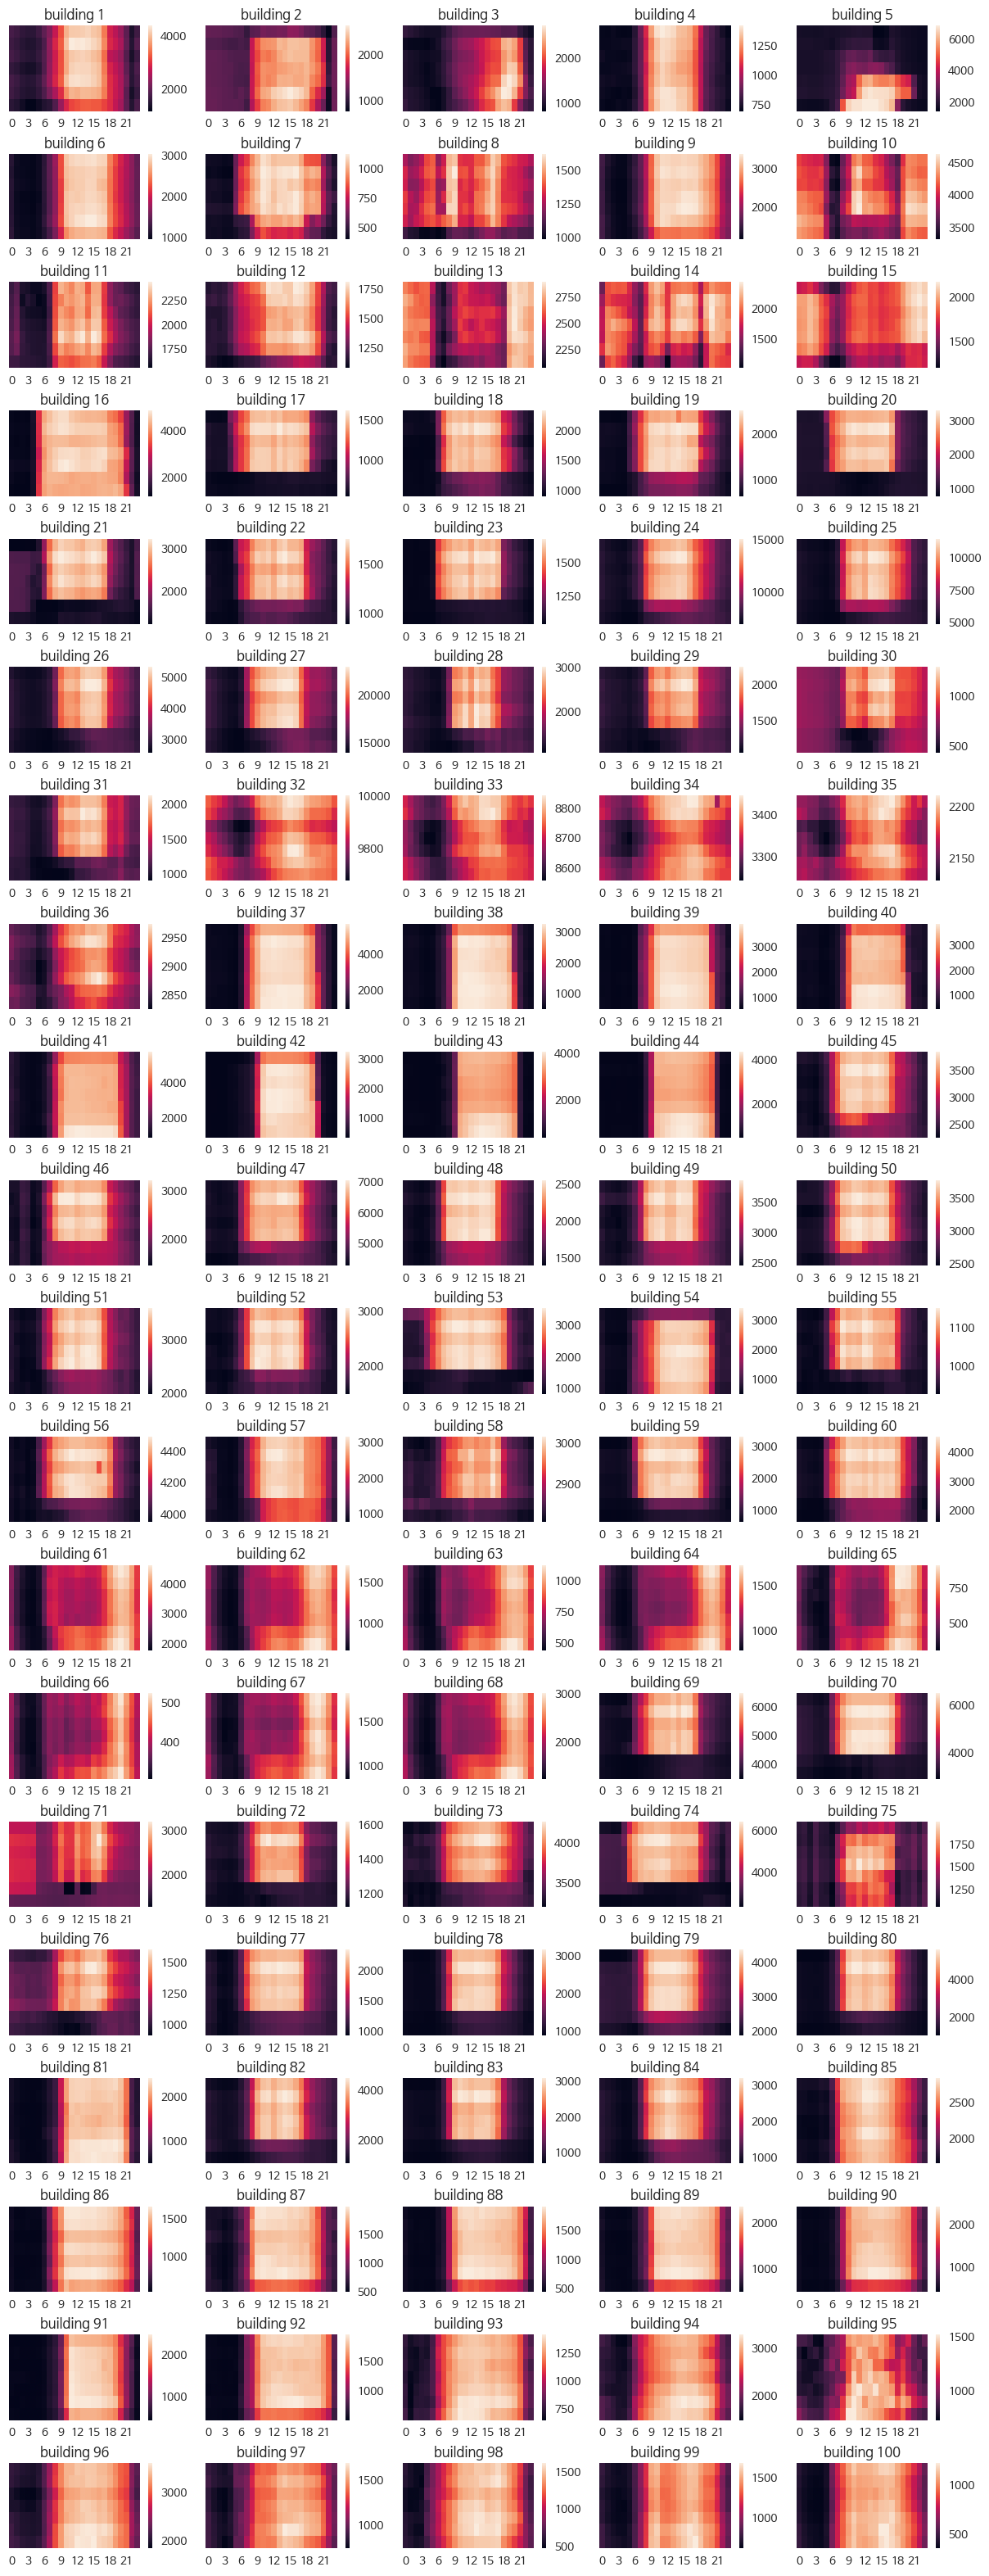

In [ ]:
# energy usage of each building ~ weekday, hour
fig = plt.figure(figsize = (15, 40))
plt.subplots_adjust(hspace=0.5)  # 간격 조절
for num in combined_df['건물번호'].unique():
    df = combined_df[combined_df['건물번호'] == num]
    df = df.groupby(['요일', '시간'])['전력소비량(kWh)'].mean().reset_index().pivot('요일', '시간', '전력소비량(kWh)')
    plt.subplot(20, 5, num)
    plt.rc('font', family='NanumBarunGothic')
    sns.heatmap(df)
    plt.title(f'building {num}')
    plt.xlabel('')
    plt.ylabel('')
    plt.yticks([])

In [ ]:
combined_df.columns.tolist()

### 군집화 수행

요일별 시간별 데이터프레임 생성

In [ ]:
# 건물을 기준으로 하는 data frame 생성
by_weekday = combined_df.groupby(['건물유형_라벨','요일'])['전력소비량(kWh)'].median().reset_index().pivot('건물유형_라벨','요일','전력소비량(kWh)').reset_index()
by_hour = combined_df.groupby(['건물유형_라벨','시간'])['전력소비량(kWh)'].median().reset_index().pivot('건물유형_라벨','시간','전력소비량(kWh)').reset_index().drop('건물유형_라벨', axis = 1)
df = pd.concat([by_weekday, by_hour], axis= 1)
columns = ['건물유형_라벨'] + ['day'+str(i) for i in range(7)] + ['hour'+str(i) for i in range(24)]
df.columns = columns

In [ ]:
by_weekday

요일,건물유형_라벨,0,1,2,3,4,5,6
0,1,1631.34,1779.615,1774.035,1800.120,1827.36,1744.335,1603.92
1,2,1469.76,1610.760,1516.320,1560.385,1519.92,1062.900,1047.33
2,3,2736.96,2812.860,2765.280,2790.960,2791.02,2049.600,2118.84
3,4,3409.56,3404.160,3369.600,3325.320,3336.03,3370.500,3388.32
4,5,1356.00,2067.300,2035.140,2030.160,2084.07,2119.200,2106.30
5,6,2778.48,2837.340,2764.920,2804.040,2805.96,2442.240,2405.22
6,7,2329.50,2821.500,2767.200,2813.280,2809.74,1589.040,1580.40
7,8,1077.12,1068.930,1024.560,1017.000,1035.09,1079.160,1117.44
8,9,2560.44,2796.720,2719.560,2795.520,2651.94,2295.360,1917.00
9,10,1848.24,2115.120,1946.820,2040.480,2048.31,1268.400,1194.96


In [ ]:
by_hour

시간,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,1376.88,1315.440,1281.60,1283.28,1316.40,1351.20,1393.9200,1458.00,1715.760,1942.08,...,2146.56,2217.60,2204.16,2099.520,1956.96,1957.68,1926.000,1797.60,1566.720,1526.88
1,974.16,961.920,959.85,961.47,967.92,1034.25,1339.2000,1538.01,1701.000,1765.98,...,1774.26,1745.10,1763.01,1712.850,1446.75,1263.36,1182.000,1103.40,1043.310,999.15
2,2093.64,2040.480,1993.92,1967.34,1946.94,1916.88,1879.9800,1911.18,2126.760,2845.98,...,3101.76,3113.94,2974.68,2914.920,2693.52,2607.30,2501.580,2386.56,2248.620,2195.28
3,3334.68,3318.840,3303.72,3299.76,3286.80,3284.64,3307.3200,3318.12,3341.520,3369.60,...,3436.56,3440.88,3452.40,3456.000,3431.88,3414.24,3397.680,3381.84,3369.600,3355.92
4,568.26,565.140,553.80,538.02,519.69,527.04,604.2600,778.23,1307.850,2709.84,...,3744.00,3708.48,3670.11,3643.440,3585.84,3429.63,2537.100,1032.57,660.000,589.47
5,2199.69,2137.680,2114.46,2123.04,2104.02,2178.90,2476.9800,2777.88,3107.760,3233.46,...,3245.40,3256.35,3237.12,3027.720,2715.24,2610.00,2489.490,2452.08,2367.180,2269.86
6,975.48,945.540,935.82,939.96,956.52,1164.78,1720.4400,2397.42,2712.960,2792.88,...,3037.44,3018.48,3031.92,3000.720,2814.66,2541.60,2163.600,1592.64,1389.420,1099.86
7,1013.67,853.380,765.63,718.20,722.28,735.93,832.9500,991.71,1056.870,1065.12,...,1102.86,1121.67,1187.31,1283.805,1400.40,1492.50,1531.485,1482.12,1395.270,1217.52
8,2413.44,2391.960,2379.60,2373.84,2389.32,2069.28,2106.5275,2195.16,2468.520,2738.52,...,2718.12,2928.12,2955.48,2756.640,2485.56,2388.24,2357.640,2260.65,2151.360,2076.84
9,1058.88,1020.420,976.56,956.34,955.98,976.86,1091.2800,1414.08,2073.420,2395.26,...,2617.56,2594.94,2553.84,2456.100,2097.72,1879.20,1629.960,1412.64,1195.560,1126.80


In [ ]:
df

,건물유형_라벨,day0,day1,day2,day3,day4,day5,day6,hour0,hour1,...,hour14,hour15,hour16,hour17,hour18,hour19,hour20,hour21,hour22,hour23
0,1,1631.34,1779.615,1774.035,1800.120,1827.36,1744.335,1603.92,1376.88,1315.440,...,2146.56,2217.60,2204.16,2099.520,1956.96,1957.68,1926.000,1797.60,1566.720,1526.88
1,2,1469.76,1610.760,1516.320,1560.385,1519.92,1062.900,1047.33,974.16,961.920,...,1774.26,1745.10,1763.01,1712.850,1446.75,1263.36,1182.000,1103.40,1043.310,999.15
2,3,2736.96,2812.860,2765.280,2790.960,2791.02,2049.600,2118.84,2093.64,2040.480,...,3101.76,3113.94,2974.68,2914.920,2693.52,2607.30,2501.580,2386.56,2248.620,2195.28
3,4,3409.56,3404.160,3369.600,3325.320,3336.03,3370.500,3388.32,3334.68,3318.840,...,3436.56,3440.88,3452.40,3456.000,3431.88,3414.24,3397.680,3381.84,3369.600,3355.92
4,5,1356.00,2067.300,2035.140,2030.160,2084.07,2119.200,2106.30,568.26,565.140,...,3744.00,3708.48,3670.11,3643.440,3585.84,3429.63,2537.100,1032.57,660.000,589.47
5,6,2778.48,2837.340,2764.920,2804.040,2805.96,2442.240,2405.22,2199.69,2137.680,...,3245.40,3256.35,3237.12,3027.720,2715.24,2610.00,2489.490,2452.08,2367.180,2269.86
6,7,2329.50,2821.500,2767.200,2813.280,2809.74,1589.040,1580.40,975.48,945.540,...,3037.44,3018.48,3031.92,3000.720,2814.66,2541.60,2163.600,1592.64,1389.420,1099.86
7,8,1077.12,1068.930,1024.560,1017.000,1035.09,1079.160,1117.44,1013.67,853.380,...,1102.86,1121.67,1187.31,1283.805,1400.40,1492.50,1531.485,1482.12,1395.270,1217.52
8,9,2560.44,2796.720,2719.560,2795.520,2651.94,2295.360,1917.00,2413.44,2391.960,...,2718.12,2928.12,2955.48,2756.640,2485.56,2388.24,2357.640,2260.65,2151.360,2076.84
9,10,1848.24,2115.120,1946.820,2040.480,2048.31,1268.400,1194.96,1058.88,1020.420,...,2617.56,2594.94,2553.84,2456.100,2097.72,1879.20,1629.960,1412.64,1195.560,1126.80


표준화

In [ ]:
# '전력사용량'이 아닌 '요일과 시간대에 따른 전력 사용량의 경향성'에 따라서만 군집화 할 것이므로, 특수한 scaling이 필요함
# standard scaling' x >  표준화
# 평균 0, 표준편차 1로 조정
for i in range(len(df)):
    # 요일 별 전력 중앙값에 대해 scaling
    df.iloc[i,1:8] = (df.iloc[i,1:8] - df.iloc[i,1:8].mean())/df.iloc[i,1:8].std()
    # 시간대별 전력 중앙값에 대해 scaling
    df.iloc[i,8:] = (df.iloc[i,8:] - df.iloc[i,8:].mean())/df.iloc[i,8:].std()

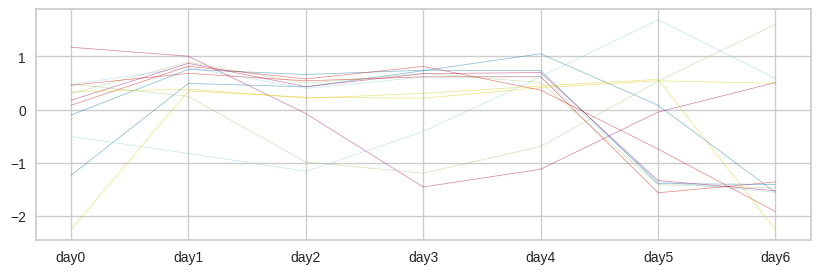

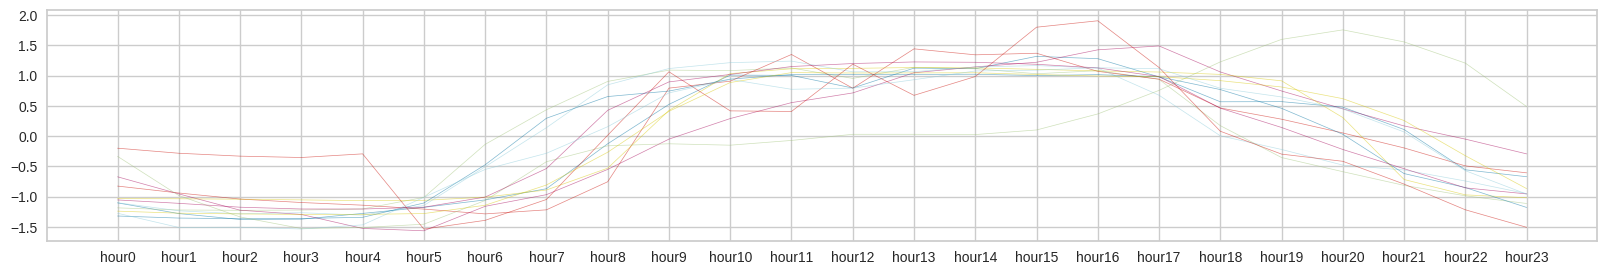

In [ ]:
# visualization
fig = plt.figure(figsize = (10,3))
for i in range(len(df)):
    plt.plot(df.iloc[i, 1:8], alpha = 0.5, linewidth = 0.5)
fig = plt.figure(figsize = (20,3))
for i in range(len(df)):
    plt.plot(df.iloc[i, 8:], alpha = 0.5, linewidth = 0.5)

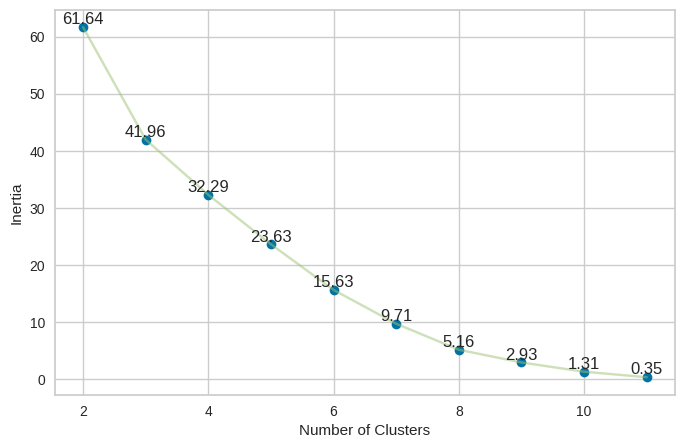

In [ ]:
def change_n_clusters(n_clusters, data):
    sum_of_squared_distance = []
    for n_cluster in n_clusters:
        kmeans = KMeans(n_clusters=n_cluster)
        kmeans.fit(data)
        sum_of_squared_distance.append(kmeans.inertia_)

    plt.figure(1 , figsize = (8, 5))
    plt.plot(n_clusters , sum_of_squared_distance , 'o')
    plt.plot(n_clusters , sum_of_squared_distance , '-' , alpha = 0.5)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')

    for i, (x, y) in enumerate(zip(n_clusters, sum_of_squared_distance)):
        plt.text(x, y, f'{y:.2f}', ha='center', va='bottom')

    return sum_of_squared_distance

# 군집화할 데이터 프레임인 df와 적절한 클러스터 개수를 지정하여 함수 호출
ssd = change_n_clusters([2,3,4,5,6,7,8,9,10,11], df.iloc[:,1:])


In [ ]:
ssd # 클러스터 개수에 따른 응집도 결과 list

[61.64462112722737,
 41.963364050423316,
 32.28567400136154,
 23.625469749900276,
 15.632441412676917,
 9.713053072071627,
 5.155042461109344,
 2.9280637113052013,
 1.3121056110171179,
 0.3459768050811023]

In [ ]:
# 클러스터 개수 4개로 지정
kmeans = KMeans(n_clusters=4, random_state = 2)
km_cluster = kmeans.fit_predict(df.iloc[:,1:])

df_clust = df.copy()
df_clust['km_cluster'] = km_cluster
df_clust['km_cluster'] = df_clust['km_cluster'].map({0:1, 1:3, 2:2, 3:0})

df_clust

,건물유형_라벨,day0,day1,day2,day3,day4,day5,day6,hour0,hour1,...,hour15,hour16,hour17,hour18,hour19,hour20,hour21,hour22,hour23,km_cluster
0,1,-1.233022,0.493279,0.428313,0.732009,1.049152,0.082529,-1.552261,-1.104439,-1.281583,...,1.319526,1.280776,0.979078,0.568049,0.570124,0.478785,0.108581,-0.557092,-0.671959,0
1,2,0.300225,0.891752,0.495555,0.680418,0.510658,-1.406645,-1.471964,-1.186759,-1.221977,...,1.031397,1.082928,0.938607,0.172981,-0.354670,-0.588760,-0.814909,-0.987800,-1.114858,3
2,3,0.458466,0.681282,0.541603,0.616991,0.617167,-1.559387,-1.356122,-0.826603,-0.941101,...,1.370965,1.071021,0.942307,0.465446,0.279741,0.052037,-0.195698,-0.492800,-0.607686,0
3,4,1.171441,1.003349,-0.072440,-1.450794,-1.117411,-0.044424,0.510279,-0.673172,-0.955824,...,1.221880,1.427445,1.491684,1.061283,0.746511,0.451012,0.168360,-0.050053,-0.294161,2
4,5,-2.250863,0.351745,0.234073,0.215852,0.413105,0.541644,0.494444,-1.034374,-1.036499,...,1.104460,1.078326,1.060161,1.020929,0.914533,0.306622,-0.718128,-0.971889,-1.019928,1
5,6,0.473407,0.792559,0.399882,0.611999,0.622410,-1.349763,-1.550494,-1.102422,-1.235610,...,1.167131,1.125828,0.676067,0.004905,-0.221135,-0.479973,-0.560324,-0.742677,-0.951707,3
6,7,-0.100396,0.755113,0.660694,0.740820,0.734664,-1.387936,-1.402960,-1.321732,-1.355785,...,1.001900,1.017186,0.981701,0.770083,0.459514,0.029591,-0.619797,-0.850932,-1.180267,3
7,8,0.478680,0.251015,-0.982379,-1.192531,-0.689667,0.535388,1.599493,-0.334857,-0.982607,...,0.101583,0.366842,0.756789,1.227963,1.600150,1.757692,1.558203,1.207232,0.488924,2
8,9,0.082628,0.815246,0.576001,0.811525,0.366336,-0.739289,-1.912445,-0.199844,-0.283374,...,1.801602,1.907998,1.134765,0.080610,-0.297840,-0.416835,-0.794002,-1.219000,-1.508787,0
9,10,0.176453,0.869926,0.432608,0.675978,0.696324,-1.330229,-1.521059,-1.055862,-1.112053,...,1.188362,1.128314,0.985514,0.461911,0.142647,-0.221499,-0.539009,-0.856169,-0.956629,3


In [ ]:
df_clust.columns.tolist()

['건물유형_라벨',
 'day0',
 'day1',
 'day2',
 'day3',
 'day4',
 'day5',
 'day6',
 'hour0',
 'hour1',
 'hour2',
 'hour3',
 'hour4',
 'hour5',
 'hour6',
 'hour7',
 'hour8',
 'hour9',
 'hour10',
 'hour11',
 'hour12',
 'hour13',
 'hour14',
 'hour15',
 'hour16',
 'hour17',
 'hour18',
 'hour19',
 'hour20',
 'hour21',
 'hour22',
 'hour23',
 'km_cluster']

요일별 시간별 전력소비량 그래프 (왼:요일, 오:시간)

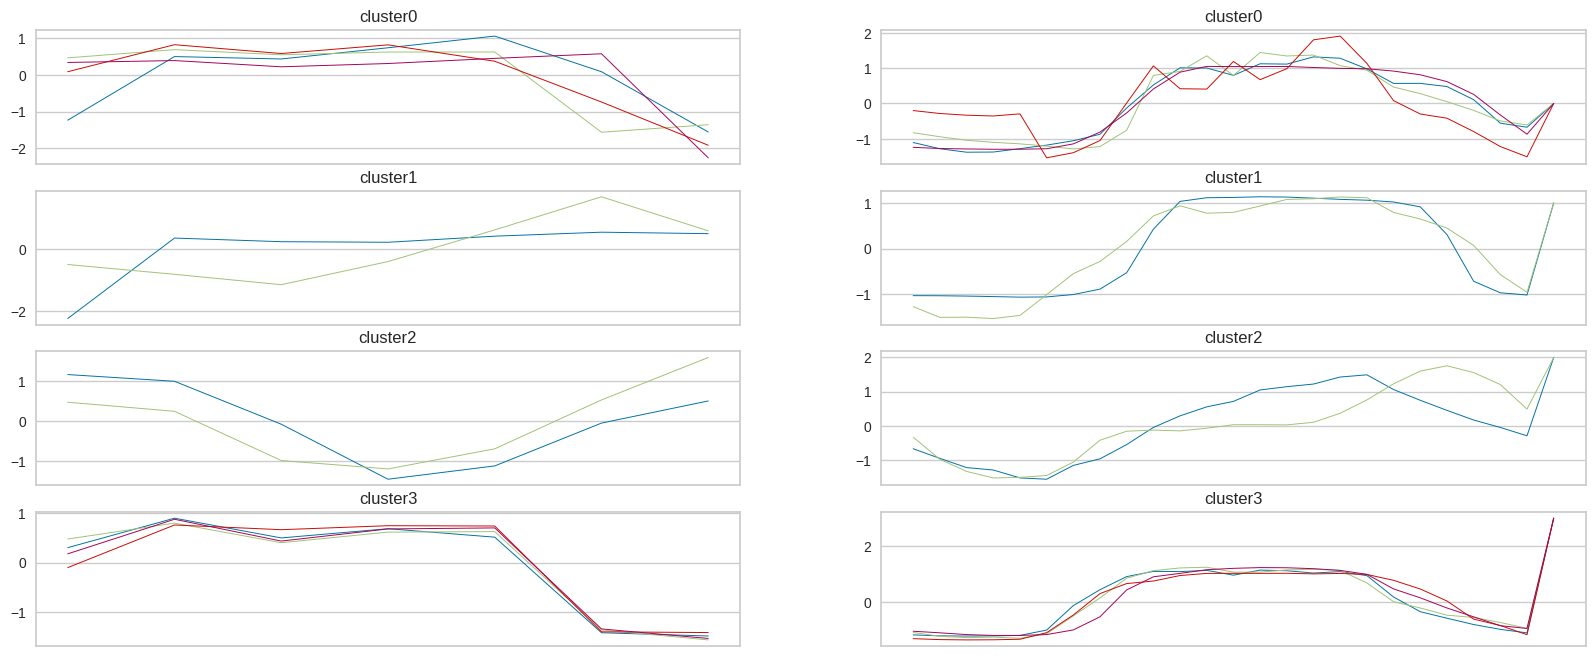

In [ ]:
# visualizing result of kmeans clustering
n_c = len(np.unique(df_clust.km_cluster))

fig = plt.figure(figsize = (20,8))
for c in range(n_c):
    temp = df_clust[df_clust.km_cluster == c]
    plt.subplot(n_c,2,2*c+1)
    for i in range(len(temp)): # 요일별
        plt.plot(temp.iloc[i,1:8], linewidth=0.7, )
        plt.title(f'cluster{c}')
        plt.xlabel('')
        plt.xticks([])
    plt.subplot(n_c,2,2*c+2)
    for i in range(len(temp)): # 시간대별
        plt.plot(temp.iloc[i,8:], linewidth=0.7) # temp.iloc[i,8:-6]
        plt.title(f'cluster{c}')
        plt.xlabel('')
        plt.xticks([])

In [ ]:
combined_clust_df = combined_df.merge(df_clust[['건물유형_라벨','km_cluster']], on = '건물유형_라벨', how = 'left')
combined_clust_df

,건물번호,일시,기온(C),풍속(m/s),습도(%),전력소비량(kWh),불쾌지수,불쾌지수_이동평균3,불쾌지수_이동평균5,holiday,...,병원,상용,아파트,연구소,지식산업센터,할인마트,호텔및리조트,건물유형_라벨,태양광여부,km_cluster
0,1,2022-06-01 00:00:00,18.6,0.9,42.0,1085.28,63.09388,63.093880,63.093880,True,...,0,0,0,0,0,0,0,1,False,0
1,1,2022-06-01 01:00:00,18.0,1.1,45.0,1047.36,62.46400,62.778940,62.778940,True,...,0,0,0,0,0,0,0,1,False,0
2,1,2022-06-01 02:00:00,17.7,1.5,45.0,974.88,62.08735,62.548410,62.548410,True,...,0,0,0,0,0,0,0,1,False,0
3,1,2022-06-01 03:00:00,16.7,1.4,48.0,953.76,60.89884,61.816730,62.136017,True,...,0,0,0,0,0,0,0,1,False,0
4,1,2022-06-01 04:00:00,18.4,2.8,43.0,986.40,62.88788,61.958023,62.286390,True,...,0,0,0,0,0,0,0,1,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203995,100,2022-08-24 19:00:00,23.1,0.9,86.0,881.04,72.38034,74.061867,74.322108,False,...,0,0,0,0,0,0,1,12,False,1
203996,100,2022-08-24 20:00:00,22.4,1.3,86.0,798.96,71.21736,72.678320,73.678128,False,...,0,0,0,0,0,0,1,12,False,1
203997,100,2022-08-24 21:00:00,21.3,1.0,92.0,825.12,69.79704,71.131580,72.640000,False,...,0,0,0,0,0,0,1,12,False,1
203998,100,2022-08-24 22:00:00,21.0,0.3,94.0,640.08,69.41060,70.141667,71.448520,False,...,0,0,0,0,0,0,1,12,False,1


In [ ]:
combined_clust_df

,건물번호,일시,기온(C),풍속(m/s),습도(%),전력소비량(kWh),불쾌지수,불쾌지수_이동평균3,불쾌지수_이동평균5,holiday,...,병원,상용,아파트,연구소,지식산업센터,할인마트,호텔및리조트,건물유형_라벨,태양광여부,km_cluster
0,1,2022-06-01 00:00:00,18.6,0.9,42.0,1085.28,63.09388,63.093880,63.093880,True,...,0,0,0,0,0,0,0,1,False,0
1,1,2022-06-01 01:00:00,18.0,1.1,45.0,1047.36,62.46400,62.778940,62.778940,True,...,0,0,0,0,0,0,0,1,False,0
2,1,2022-06-01 02:00:00,17.7,1.5,45.0,974.88,62.08735,62.548410,62.548410,True,...,0,0,0,0,0,0,0,1,False,0
3,1,2022-06-01 03:00:00,16.7,1.4,48.0,953.76,60.89884,61.816730,62.136017,True,...,0,0,0,0,0,0,0,1,False,0
4,1,2022-06-01 04:00:00,18.4,2.8,43.0,986.40,62.88788,61.958023,62.286390,True,...,0,0,0,0,0,0,0,1,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203995,100,2022-08-24 19:00:00,23.1,0.9,86.0,881.04,72.38034,74.061867,74.322108,False,...,0,0,0,0,0,0,1,12,False,1
203996,100,2022-08-24 20:00:00,22.4,1.3,86.0,798.96,71.21736,72.678320,73.678128,False,...,0,0,0,0,0,0,1,12,False,1
203997,100,2022-08-24 21:00:00,21.3,1.0,92.0,825.12,69.79704,71.131580,72.640000,False,...,0,0,0,0,0,0,1,12,False,1
203998,100,2022-08-24 22:00:00,21.0,0.3,94.0,640.08,69.41060,70.141667,71.448520,False,...,0,0,0,0,0,0,1,12,False,1


클러스터별 건물유형 출력

In [ ]:
for cluster_num in range(4):
    buildings_in_cluster = combined_clust_df[combined_clust_df['km_cluster'] == cluster_num]['건물유형_라벨'].unique()
    print(f'Cluster {cluster_num}: {buildings_in_cluster}')

Cluster 0: [ 1  3  9 11]
Cluster 1: [ 5 12]
Cluster 2: [4 8]
Cluster 3: [ 2  6  7 10]


In [ ]:
for cluster_num in range(4):
    buildings_in_cluster = combined_clust_df[combined_clust_df['km_cluster'] == cluster_num]['건물유형_라벨'].unique()
    arr = list()
    for df in buildings_in_cluster:
      btype = binfo_df[binfo_df['건물유형_라벨'] == df]['건물유형'].values[0]
      arr.append(btype)
    print(f'Cluster {cluster_num}: {arr}')

Cluster 0: ['건물기타', '대학교', '연구소', '할인마트']
Cluster 1: ['백화점및아울렛', '호텔및리조트']
Cluster 2: ['데이터센터', '아파트']
Cluster 3: ['공공', '병원', '상용', '지식산업센터']


클러스터별 전력소비량 그래프

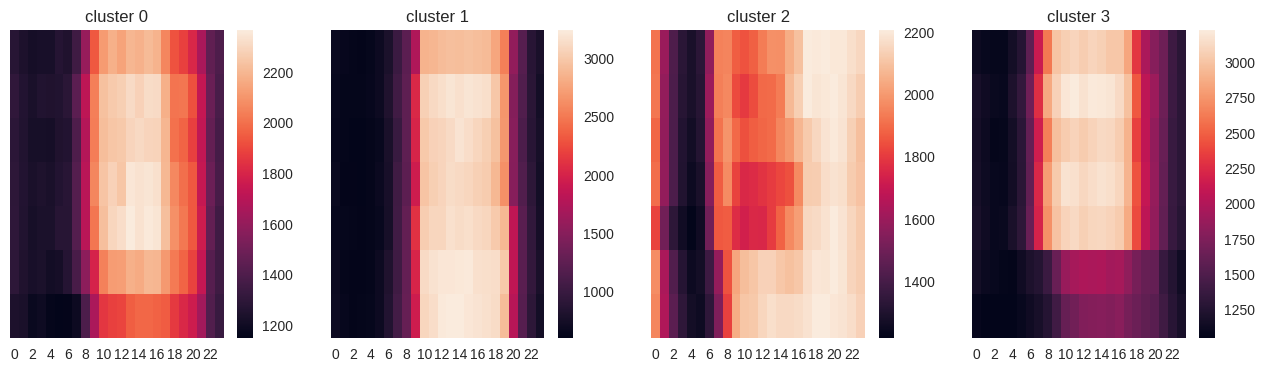

In [ ]:
fig = plt.figure(figsize = (20, 4))
for c in range(4):
    temp = combined_clust_df[combined_clust_df.km_cluster == c]
    temp = temp.groupby(['요일', '시간'])['전력소비량(kWh)'].median().reset_index().pivot('요일', '시간', '전력소비량(kWh)')
    plt.subplot(1, 5, c+1)
    sns.heatmap(temp)
    plt.title(f'cluster {c}')
    plt.xlabel('')
    plt.ylabel('')
    plt.yticks([])

In [ ]:
# dictionary mapping cluster and building
match = df_clust[['건물유형_라벨','km_cluster']]
clust_to_num = {0:[],1:[],2:[],3:[]}
for i in range(12):
    c = match.iloc[i,1]
    clust_to_num[c].append(i+1)

In [ ]:
clust_to_num

{0: [1, 3, 9, 11], 1: [5, 12], 2: [4, 8], 3: [2, 6, 7, 10]}

In [ ]:
combined_clust_df['datetime'] = pd.to_datetime('2022-' + combined_clust_df['월'].astype(str) + '-' + combined_clust_df['일'].astype(str))
combined_clust_df

,건물번호,일시,기온(C),풍속(m/s),습도(%),전력소비량(kWh),불쾌지수,불쾌지수_이동평균3,불쾌지수_이동평균5,holiday,...,상용,아파트,연구소,지식산업센터,할인마트,호텔및리조트,건물유형_라벨,태양광여부,km_cluster,datetime
0,1,2022-06-01 00:00:00,18.6,0.9,42.0,1085.28,63.09388,63.093880,63.093880,True,...,0,0,0,0,0,0,1,False,0,2022-06-01
1,1,2022-06-01 01:00:00,18.0,1.1,45.0,1047.36,62.46400,62.778940,62.778940,True,...,0,0,0,0,0,0,1,False,0,2022-06-01
2,1,2022-06-01 02:00:00,17.7,1.5,45.0,974.88,62.08735,62.548410,62.548410,True,...,0,0,0,0,0,0,1,False,0,2022-06-01
3,1,2022-06-01 03:00:00,16.7,1.4,48.0,953.76,60.89884,61.816730,62.136017,True,...,0,0,0,0,0,0,1,False,0,2022-06-01
4,1,2022-06-01 04:00:00,18.4,2.8,43.0,986.40,62.88788,61.958023,62.286390,True,...,0,0,0,0,0,0,1,False,0,2022-06-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203995,100,2022-08-24 19:00:00,23.1,0.9,86.0,881.04,72.38034,74.061867,74.322108,False,...,0,0,0,0,0,1,12,False,1,2022-08-24
203996,100,2022-08-24 20:00:00,22.4,1.3,86.0,798.96,71.21736,72.678320,73.678128,False,...,0,0,0,0,0,1,12,False,1,2022-08-24
203997,100,2022-08-24 21:00:00,21.3,1.0,92.0,825.12,69.79704,71.131580,72.640000,False,...,0,0,0,0,0,1,12,False,1,2022-08-24
203998,100,2022-08-24 22:00:00,21.0,0.3,94.0,640.08,69.41060,70.141667,71.448520,False,...,0,0,0,0,0,1,12,False,1,2022-08-24


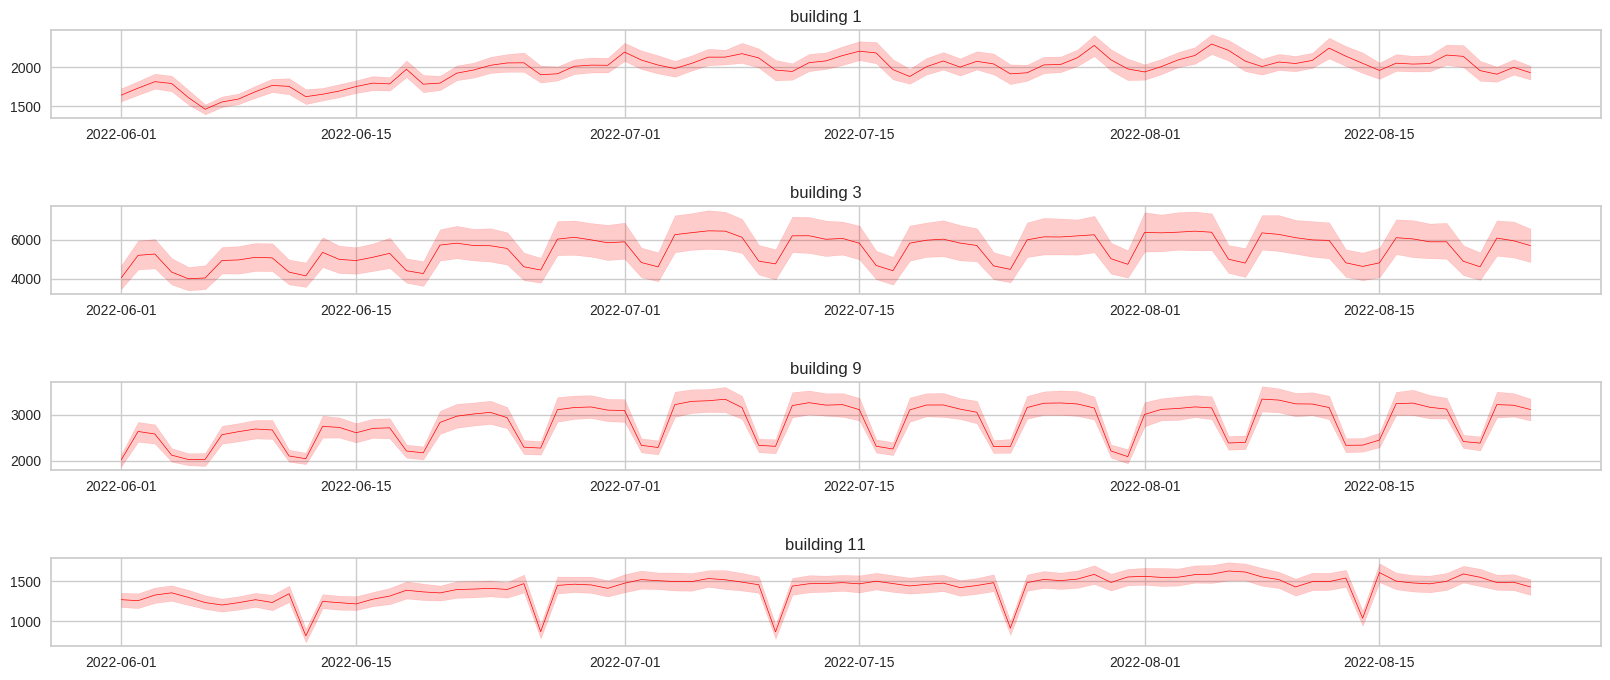

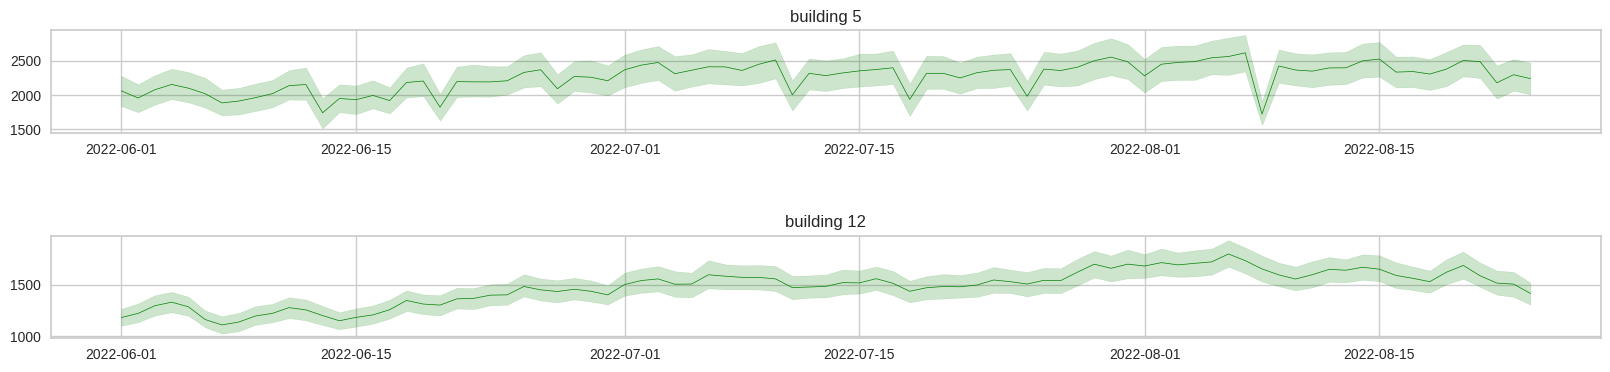

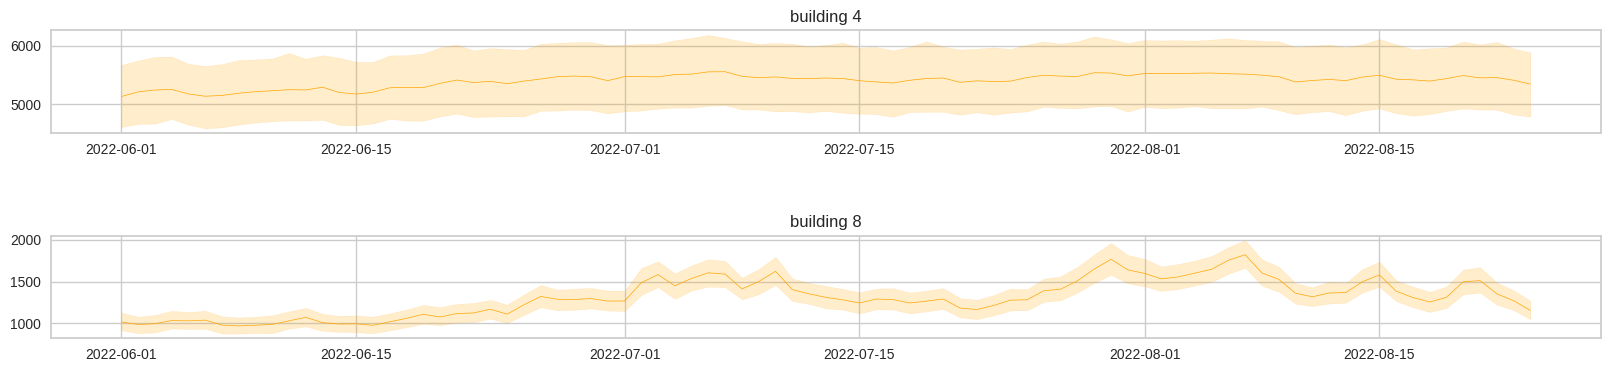

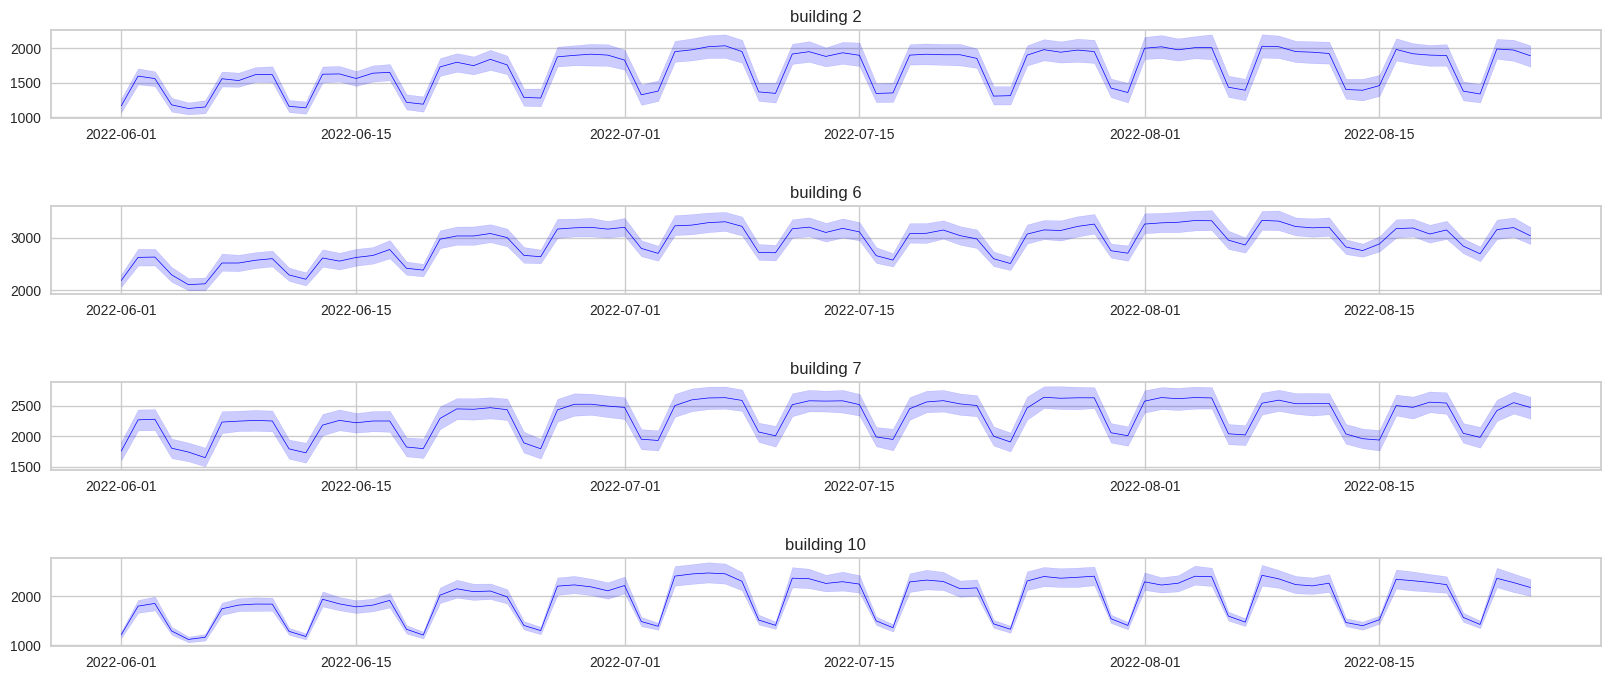

In [ ]:
# linplot(energy usage of each building ~ cluster, datetime)
for c, col in enumerate(['red','green','orange','blue']):
    temp_1 = combined_clust_df[combined_clust_df.km_cluster == c]
    nums = np.unique(temp_1['건물유형_라벨'])
    n_nums = len(nums)
    fig = plt.figure(figsize = (20, 2*n_nums))
    for i, num in enumerate(nums):
        temp_2 = temp_1[temp_1['건물유형_라벨'] == num]
        plt.subplot(n_nums,1, i+1)
        sns.lineplot(data = temp_2, x= 'datetime', y = '전력소비량(kWh)', linewidth = 0.5, color = col)
        plt.title(f'building {num}')
        plt.subplots_adjust(hspace = 1)
        plt.ylabel('')
        plt.xlabel('')

In [ ]:
combined_clust_df.columns.tolist()

['건물번호',
 '일시',
 '기온(C)',
 '풍속(m/s)',
 '습도(%)',
 '전력소비량(kWh)',
 '불쾌지수',
 '불쾌지수_이동평균3',
 '불쾌지수_이동평균5',
 'holiday',
 '월',
 '일',
 '시간',
 '시간_sin',
 '시간_cos',
 '요일',
 '건물유형',
 '연면적(m2)',
 '냉방면적(m2)',
 '태양광용량(kW)',
 'ESS저장용량(kWh)',
 '건물기타',
 '공공',
 '대학교',
 '데이터센터',
 '백화점및아울렛',
 '병원',
 '상용',
 '아파트',
 '연구소',
 '지식산업센터',
 '할인마트',
 '호텔및리조트',
 '건물유형_라벨',
 '태양광여부',
 'km_cluster',
 'datetime']

### 각 군집별로 모델 생성(et) +모델별 feature 추가

In [ ]:
combined_clust_df.columns.tolist()

['건물번호',
 '일시',
 '기온(C)',
 '풍속(m/s)',
 '습도(%)',
 '전력소비량(kWh)',
 '불쾌지수',
 '불쾌지수_이동평균3',
 '불쾌지수_이동평균5',
 'holiday',
 '월',
 '일',
 '시간',
 '시간_sin',
 '시간_cos',
 '요일',
 '건물유형',
 '연면적(m2)',
 '냉방면적(m2)',
 '태양광용량(kW)',
 'ESS저장용량(kWh)',
 '건물기타',
 '공공',
 '대학교',
 '데이터센터',
 '백화점및아울렛',
 '병원',
 '상용',
 '아파트',
 '연구소',
 '지식산업센터',
 '할인마트',
 '호텔및리조트',
 '건물유형_라벨',
 '태양광여부',
 'km_cluster',
 'datetime']

Cluster 0: ['건물기타', '대학교', '연구소', '할인마트']  
Cluster 1: ['백화점및아울렛', '호텔및리조트']  
Cluster 2: ['데이터센터', '아파트']  
Cluster 3: ['공공', '병원', '상용', '지식산업센터']

In [ ]:
clust_to_num

{0: [1, 3, 9, 11], 1: [5, 12], 2: [4, 8], 3: [2, 6, 7, 10]}

#### clust0

In [ ]:
selected_columns0 = ['전력소비량(kWh)',
 '연면적(m2)',
 '건물번호',
 '시간_cos',
 '연구소',
 'holiday',
 '냉방면적(m2)',
 'ESS저장용량(kWh)',
 '불쾌지수',
 '대학교',
 '시간',
 '시간_sin',
 '불쾌지수_이동평균3',
 '태양광용량(kW)',
 '월',
 '불쾌지수_이동평균5',
 '기온(C)',
 '요일',
 '일',
 '습도(%)',
 '풍속(m/s)',
 'km_cluster']
combined_clust_train_df = combined_clust_df[selected_columns0]

clust0_train_df = combined_clust_train_df[combined_clust_train_df['km_cluster'] == 0].reset_index(drop=True)



In [ ]:

# pycaret 설정
exp0 = setup(data=clust0_train_df.drop(columns=['km_cluster']), target='전력소비량(kWh)')

# 기본 모델 생성
et_model0 = create_model('et')

# 하이퍼파라미터 튜닝 및 최적 모델 생성
et_tune_model0 = tune_model(et_model0)

# 최종 모델 생성
final_et_model0 = finalize_model(et_tune_model0)

# 모델 저장
save_model(final_et_model0, path+'et_model_final0')



,Description,Value
0,Session id,1723
1,Target,전력소비량(kWh)
2,Target type,Regression
3,Original data shape,"(79560, 21)"
4,Transformed data shape,"(79560, 21)"
5,Transformed train set shape,"(55692, 21)"
6,Transformed test set shape,"(23868, 21)"
7,Numeric features,19
8,Preprocess,True
9,Imputation type,simple


,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,14:36:36
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Extra Trees Regressor


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,89.2273,24072.8863,155.1544,0.9976,0.0821,0.0457
1,87.3129,22932.0460,151.4333,0.9979,0.0767,0.0432
2,87.2392,22756.6882,150.8532,0.9976,0.0805,0.0447
3,89.5562,26908.3850,164.0378,0.9974,0.0872,0.0470
4,91.9027,26097.1817,161.5462,0.9976,0.0845,0.0460
5,88.0375,26040.3106,161.3701,0.9973,0.0833,0.0459
6,86.0752,22376.3207,149.5872,0.9978,0.0830,0.0452
7,84.6328,21400.3898,146.2887,0.9979,0.0803,0.0446
8,87.4640,23696.5762,153.9369,0.9977,0.0795,0.0445


Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=FastMemory(location=/tmp/joblib),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['연면적(m2)', '건물번호', '시간_cos', '연구소',
                                              '냉방면적(m2)', 'ESS저장용량(kWh)', '불쾌지수',
                                              '대학교', '시간', '시간_sin',
                                              '불쾌지수_이동평균3', '태양광용량(kW)', '월',
                                              '불쾌지수_이동평균5', '기온(C)', '요일', '일',
                                              '습도(%)', '풍속(m/s)'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=[],
                                     transformer=SimpleImputer(strategy='most_frequent'))),
                 ('clean_column_names',
                  TransformerWrapper(transformer=CleanColumnNames())),
                 ('actual_estimator',
                  ExtraTreesRegressor(n_jobs=-1, rand

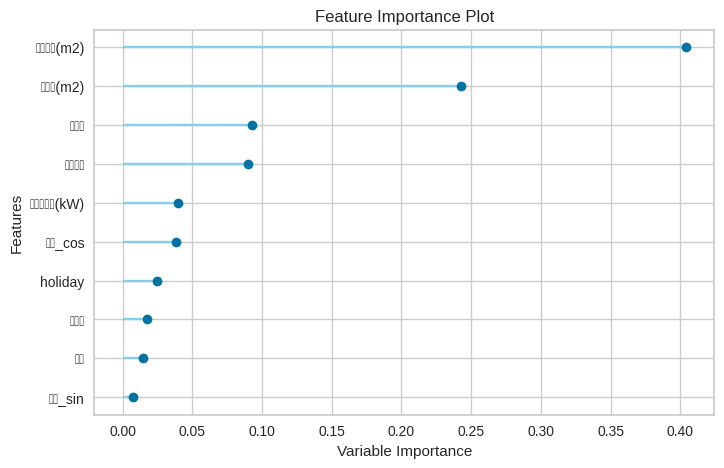

In [ ]:
# 변수 중요도 그래프
plot_model(estimator = et_model, plot = 'feature')



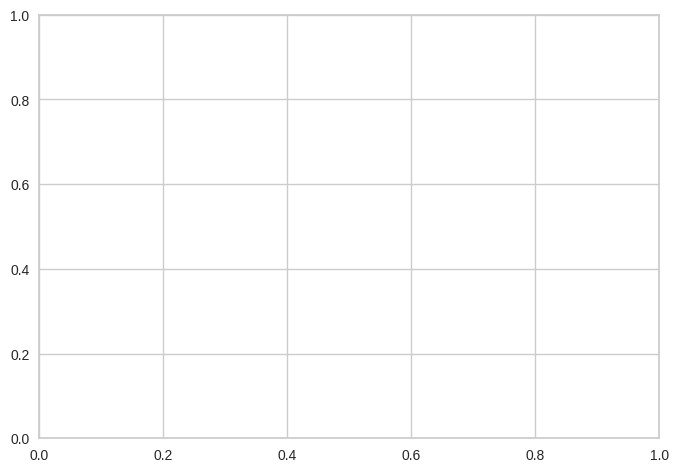

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [ ]:
# 모델 평가
evaluate_model(et_model)



#### clust1

In [ ]:
selected_columns1 = ['전력소비량(kWh)',
 '시간_cos',
 '냉방면적(m2)',
 '시간',
 '연면적(m2)',
 '시간_sin',
 '건물번호',
 '불쾌지수_이동평균3',
 '월',
 '불쾌지수',
 'holiday',
 '요일',
 '불쾌지수_이동평균5',
 '태양광용량(kW)',
 '일',
 'km_cluster']
combined_clust_train_df = combined_clust_df[selected_columns1]

clust1_train_df = combined_clust_train_df[combined_clust_train_df['km_cluster'] == 1].reset_index(drop=True)



In [ ]:

# pycaret 설정
exp1 = setup(data=clust1_train_df.drop(columns=['km_cluster']), target='전력소비량(kWh)')

# 기본 모델 생성
et_model1 = create_model('et')

# 하이퍼파라미터 튜닝 및 최적 모델 생성
et_tune_model1 = tune_model(et_model1)

# 최종 모델 생성
final_et_model1 = finalize_model(et_tune_model1)

# 모델 저장
save_model(final_et_model1, path+'et_model_final1')




,Description,Value
0,Session id,4833
1,Target,전력소비량(kWh)
2,Target type,Regression
3,Original data shape,"(32640, 15)"
4,Transformed data shape,"(32640, 15)"
5,Transformed train set shape,"(22848, 15)"
6,Transformed test set shape,"(9792, 15)"
7,Numeric features,13
8,Preprocess,True
9,Imputation type,simple


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,75.4297,21406.4068,146.3093,0.9884,0.0976,0.0536
1,75.8261,17417.7080,131.9762,0.9909,0.0958,0.0559
2,74.9607,21565.0869,146.8506,0.9885,0.1781,0.0553
3,76.7542,23293.6361,152.6225,0.9878,0.1027,0.0565
4,74.9260,21256.1285,145.7948,0.9888,0.0951,0.0543
5,77.3008,27253.2775,165.0857,0.9856,0.1025,0.0568
6,73.9058,20225.0738,142.2149,0.9891,0.0885,0.0523
7,75.7285,20432.2766,142.9415,0.9886,0.0955,0.0552
8,74.8383,20157.9269,141.9786,0.9891,0.0972,0.0541


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=FastMemory(location=/tmp/joblib),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['시간_cos', '냉방면적(m2)', '시간',
                                              '연면적(m2)', '시간_sin', '건물번호',
                                              '불쾌지수_이동평균3', '월', '불쾌지수', '요일',
                                              '불쾌지수_이동평균5', '태양광용량(kW)', '일'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=[],
                                     transformer=SimpleImputer(strategy='most_frequent'))),
                 ('clean_column_names',
                  TransformerWrapper(transformer=CleanColumnNames())),
                 ('actual_estimator',
                  ExtraTreesRegressor(n_jobs=-1, random_state=4833))]),
 '/content/drive/MyDrive/Colab Notebooks/dacon/et_model_final1.pkl')

#### clust2

In [ ]:
selected_columns2 = ['전력소비량(kWh)',
 '건물번호',
 '냉방면적(m2)',
 '불쾌지수_이동평균5',
 '연면적(m2)',
 '시간',
 '불쾌지수',
 '월',
 '시간_sin',
 '불쾌지수_이동평균3',
 'holiday',
 '시간_cos',
 '일',
 '습도(%)',
 '요일',
 '기온(C)',
 '풍속(m/s)',
 'km_cluster']
combined_clust_train_df = combined_clust_df[selected_columns2]

clust2_train_df = combined_clust_train_df[combined_clust_train_df['km_cluster'] == 2].reset_index(drop=True)


In [ ]:

# pycaret 설정
exp2 = setup(data=clust2_train_df.drop(columns=['km_cluster']), target='전력소비량(kWh)')

# 기본 모델 생성
et_model2 = create_model('et')

# 하이퍼파라미터 튜닝 및 최적 모델 생성
et_tune_model2 = tune_model(et_model2)

# 최종 모델 생성
final_et_model2 = finalize_model(et_tune_model2)

# 모델 저장
save_model(final_et_model2, path+'et_model_final2')



#### clust3

In [ ]:
selected_columns3 = ['전력소비량(kWh)',
 '병원',
 '시간_cos',
 '연면적(m2)',
 'holiday',
 '냉방면적(m2)',
 '건물번호',
 '태양광용량(kW)',
 'ESS저장용량(kWh)',
 '불쾌지수',
 '시간_sin',
 '상용',
 '월',
 '불쾌지수_이동평균3',
 '시간',
 '불쾌지수_이동평균5',
 '요일',
 '기온(C)',
 '일',
 '습도(%)',
 'km_cluster']
combined_clust_train_df = combined_clust_df[selected_columns3]

clust3_train_df = combined_clust_train_df[combined_clust_train_df['km_cluster'] == 3].reset_index(drop=True)



In [ ]:

# pycaret 설정
exp3 = setup(data=clust3_train_df.drop(columns=['km_cluster']), target='전력소비량(kWh)')

# 기본 모델 생성
et_model3 = create_model('et')

# 하이퍼파라미터 튜닝 및 최적 모델 생성
et_tune_model3 = tune_model(et_model3)

# 최종 모델 생성
final_et_model3 = finalize_model(et_tune_model3)

# 모델 저장
save_model(final_et_model3, path+'et_model_final3')



#### 예측

In [ ]:
test_df.columns.tolist()

['건물번호',
 '일시',
 '기온(C)',
 '풍속(m/s)',
 '습도(%)',
 '불쾌지수',
 '불쾌지수_이동평균3',
 '불쾌지수_이동평균5',
 'holiday',
 '월',
 '일',
 '시간',
 '시간_sin',
 '시간_cos',
 '요일',
 '연면적(m2)',
 '냉방면적(m2)',
 '태양광용량(kW)',
 'ESS저장용량(kWh)',
 '건물기타',
 '공공',
 '대학교',
 '데이터센터',
 '백화점및아울렛',
 '병원',
 '상용',
 '아파트',
 '연구소',
 '지식산업센터',
 '할인마트',
 '호텔및리조트',
 '건물유형_라벨',
 '태양광여부']

In [ ]:
selected_columns0.append('건물유형_라벨')
selected_columns1.append('건물유형_라벨')
selected_columns2.append('건물유형_라벨')
selected_columns3.append('건물유형_라벨')

rm_list = ['전력소비량(kWh)', 'km_cluster']
for value in rm_list:
    selected_columns0.remove(value)
    selected_columns1.remove(value)
    selected_columns2.remove(value)
    selected_columns3.remove(value)

test_df_list = [test_df[selected_columns0],test_df[selected_columns1],test_df[selected_columns2],test_df[selected_columns3]]

In [ ]:
from pycaret.regression import *
from sklearn.metrics import mean_squared_error

# 예측값을 저장할 컬럼
test_df['answer'] = np.nan

# 각 클러스터 모델에 대해 예측 수행
for cluster, building_labels in clust_to_num.items():
    # 해당 클러스터의 모델 불러오기
    cluster_model = joblib.load(path+'et_model_final'+str(cluster)+'.pkl')

    # 건물유형라벨이 해당 클러스터에 속하는 테스트 데이터 선택
    cluster_test_data = test_df_list[cluster][test_df_list[cluster]['건물유형_라벨'].isin(building_labels)]
    cluster_test_data = cluster_test_data.drop(columns=['건물유형_라벨'])
    index_list = cluster_test_data.index.tolist()

    # 정규화 수행
    # if cluster == 0:
    #   scaler = StandardScaler()
    #   cluster_test_data = scaler.fit_transform(cluster_test_data)
    # elif cluster == 3:
    #   scaler = MinMaxScaler()
    #   cluster_test_data = scaler.fit_transform(cluster_test_data)

    # 불러온 모델로 예측 수행
    predictions = predict_model(cluster_model, cluster_test_data)


    # index_list와 predictions를 이용하여 데이터프레임 생성
    answer_df = pd.DataFrame({'answer': predictions['prediction_label']}, index=index_list)

    # 예측 결과를 원래 데이터프레임에 추가
    test_df.loc[answer_df.index, 'answer'] = answer_df['answer']



test_df

In [ ]:
sum(test_df['answer'].isna())

In [ ]:
# 데이터 불러오기
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dacon/sample_submission.csv')

df['answer'] = test_df['answer']
df.to_csv(path+'submit_clust_et_model_fianl.csv', index=False)

##pycaret

In [ ]:

# pycaret 설정
exp1 = setup(data=combined_df, target='전력소비량(kWh)')

# 모델 학습 및 비교
best_model = compare_models()

# 결과 출력
print(best_model)


In [ ]:
# 모델 생성
et_model = create_model('et')
#rf_model = create_model('rf')
#dt_model = create_model('dt')

In [ ]:
# 선택한 모델 튜닝
#et_tune_model = tune_model(et_model)
#rf_tune_model = tune_model('rf')
#dt_tune_model = tune_model('dt')


In [ ]:
# 모델 저장
save_model(rf_model, 'rf_model_saved')

In [ ]:
# 변수 중요도 그래프
plot_model(estimator = et_model, plot = 'feature')

# 모델 평가
evaluate_model(et_model)

In [ ]:
# 예측
et_final = finalize_model(rf_model)
pred = predict_model(et_final,test_df)

In [ ]:
pred

,풍속(m/s),습도(%),불쾌지수,기온_정규화,holiday,월,일,시간,연면적(m2),냉방면적(m2),...,데이터센터,백화점및아울렛,병원,상용,아파트,연구소,지식산업센터,할인마트,호텔및리조트,prediction_label
0,2.2,72,71.789803,0.562189,False,8,25,0,110634.000000,39570.000000,...,0,0,0,0,0,0,0,0,0,2147.808015
1,0.9,72,71.028397,0.537313,False,8,25,1,110634.000000,39570.000000,...,0,0,0,0,0,0,0,0,0,2174.399982
2,1.5,75,70.816750,0.522388,False,8,25,2,110634.000000,39570.000000,...,0,0,0,0,0,0,0,0,0,2022.441615
3,1.3,78,70.112617,0.492537,False,8,25,3,110634.000000,39570.000000,...,0,0,0,0,0,0,0,0,0,1986.705614
4,1.0,77,69.565140,0.477612,False,8,25,4,110634.000000,39570.000000,...,0,0,0,0,0,0,0,0,0,1975.977611
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16795,0.9,84,71.223999,0.512438,False,8,31,19,57497.839844,40035.230469,...,0,0,0,0,0,0,0,0,1,937.954191
16796,0.4,95,68.950348,0.422886,False,8,31,20,57497.839844,40035.230469,...,0,0,0,0,0,0,0,0,1,837.597007
16797,0.4,98,68.246040,0.398010,False,8,31,21,57497.839844,40035.230469,...,0,0,0,0,0,0,0,0,1,853.410597
16798,1.1,97,68.012032,0.393035,False,8,31,22,57497.839844,40035.230469,...,0,0,0,0,0,0,0,0,1,685.456815


In [ ]:
pred.columns.tolist()

['풍속(m/s)',
 '습도(%)',
 '불쾌지수',
 '기온_정규화',
 'holiday',
 '월',
 '일',
 '시간',
 '연면적(m2)',
 '냉방면적(m2)',
 '태양광용량(kW)',
 'ESS저장용량(kWh)',
 '건물기타',
 '공공',
 '대학교',
 '데이터센터',
 '백화점및아울렛',
 '병원',
 '상용',
 '아파트',
 '연구소',
 '지식산업센터',
 '할인마트',
 '호텔및리조트',
 'prediction_label']

In [ ]:
# 데이터 불러오기
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dacon/sample_submission.csv')

df['answer'] = pred['prediction_label']
df.to_csv('submit_et.csv', index=False)